In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import scipy
import GPy
import plot

In [3]:
import importlib
importlib.reload(plot)

<module 'plot' from '/Users/pdt2/dev/stochastic-sampling-bayesian-optimization/plot.py'>

In [9]:
from marginal import mc, gaussian
importlib.reload(mc)
importlib.reload(gaussian)

<module 'marginal.gaussian' from '/Users/pdt2/dev/stochastic-sampling-bayesian-optimization/marginal/gaussian.py'>

# simulate some data

In [4]:
def f(x):
    x = np.array(x)
    x = x/2
    return np.cos(x*20) + np.sin(x*2*np.pi - 10*x**2) - 3*x**4

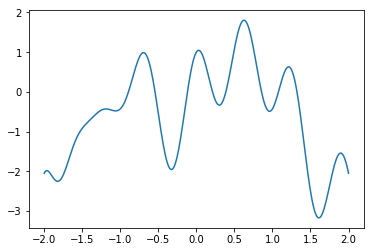

In [5]:
x = np.linspace(-2, 2, 300)
plt.plot(x, f(x))

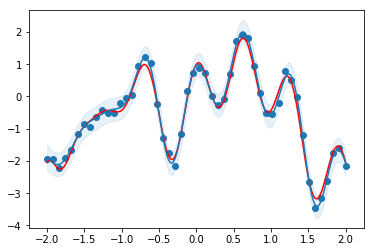

In [6]:
xsamp = [-.3, -.15, .1]
xsamp = np.linspace(-2, 2, 50)

ystd = .2
ysamp = f(xsamp) + scipy.stats.norm(0, ystd).rvs(size=len(xsamp))

m = GPy.models.GPRegression(np.array(xsamp)[:,None], np.array(ysamp)[:,None], GPy.kern.RBF(1))
m.optimize()

plt.plot(x, f(x), 'r')
plt.scatter(xsamp, ysamp)
plot.interval(x[:,None], *m.predict(x[:,None]))

# monte carlo

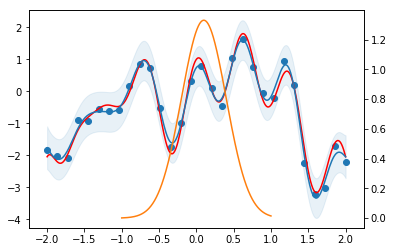

In [270]:
px = scipy.stats.norm(.1, .3)

plt.plot(x, f(x), 'r')
plt.scatter(xsamp, ysamp)
plot.interval(x[:,None], *m.predict(x[:,None]))

plt.twinx()
z = np.linspace(-1, 1, 1000)
plt.plot(z, px.pdf(z), c='C1')

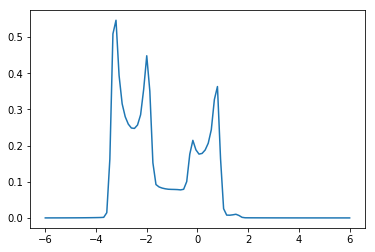

In [231]:
z = np.linspace(-6, 6, 100)
mcm = mc.MonteCarlo(m, px, 500000)

plt.plot(z, mcm.pdf(z))

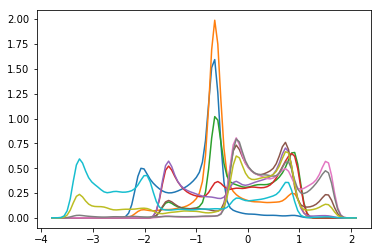

In [232]:
z = np.linspace(-3.8, 2.1, 100)
for mm in np.linspace(-1.5, 1.5, 10):
    px = scipy.stats.norm(mm, .3)
    mcm = mc.MonteCarlo(m, px, 5000)

    plt.plot(z, mcm.pdf(z))

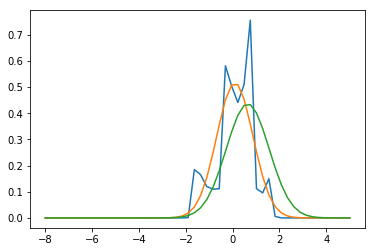

In [458]:
mcm = mc.MonteCarlo(m, px, 500000)

z = np.linspace(-8, 5)
plt.plot(z, mcm.pdf(z))

approx = scipy.stats.norm(mcm.mean(), mcm.var()**.5)
plt.plot(z, approx.pdf(z))

taylor = gaussian.GaussianApprox(m, px)
plt.plot(z, taylor.pdf(z))

[]

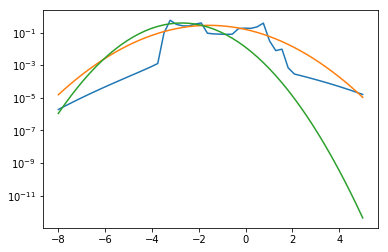

In [254]:
plt.plot(z, mcm.pdf(z))
plt.plot(z, approx.pdf(z))
plt.plot(z, taylor.pdf(z))

plt.semilogy()

[]

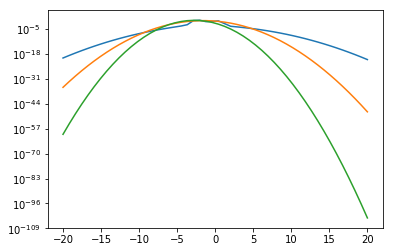

In [255]:
z = np.linspace(-20, 20)
plt.plot(z, mcm.pdf(z))
plt.plot(z, approx.pdf(z))
plt.plot(z, taylor.pdf(z))

plt.semilogy()

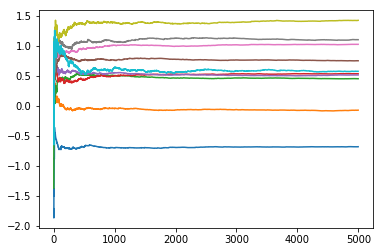

In [224]:
z = np.linspace(-3.8, 2.1, 100)
for mm in np.linspace(-1.5, 1.5, 10):
    px = scipy.stats.norm(mm, .3)
    mcm = mc.MonteCarlo(m, px, 5000)
    plt.plot([mcm.mean(slice(0, i)) + mcm.var(slice(0, i)) for i in range(1, mcm.T)])  

 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


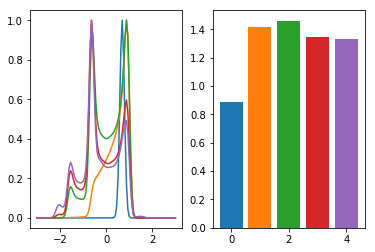

In [459]:
z = np.linspace(-3, 3, 100)

for i, s in enumerate(np.linspace(.005, .5, 5)):
    px = scipy.stats.norm(-.8, s)

    mcm = mc.MonteCarlo(m, px, 100000)
    
    plt.subplot(121)
    plt.plot(z, mcm.pdf(z)/max(mcm.pdf(z)))
    
    plt.subplot(122)
    plt.bar([i], mcm.mean() + 2*(mcm.var()**.5))

Text(0, 0.5, '$\\mu$')

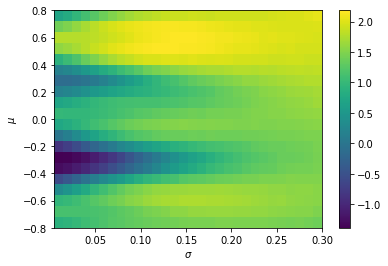

In [223]:
stds = np.linspace(.005, .3, 30)
mus = np.linspace(-.8, .8, 20)

aqs = np.zeros((mus.shape[0], stds.shape[0]))

for i, mu in enumerate(mus):
    for j, s in enumerate(stds):
        px = scipy.stats.norm(mu, s)
        mcm = mc.MonteCarlo(m, px, 10000)
        
        aqs[i,j] = mcm.mean() + 2*np.sqrt(mcm.var())
        
plt.imshow(aqs, origin='bottom', extent=(stds.min(), stds.max(), mus.min(), mus.max()), aspect='auto')
plt.colorbar()
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

# wsabi 

In [54]:
class WSABI():
    
    def __init__(self, x, lx, alpha_weight = .8):
        self.x = x
        
        self.mu_x = np.mean(self.x, 0)
        self.std_x = np.std(self.x, 0)
        
        self.x = (self.x-self.mu_x)/self.std_x
        
        self.lx = lx
        self.alpha_weight = alpha_weight
        self.lx_transform = np.sqrt(2*self.lx - self.alpha)
        
        self.m = GPy.models.GPRegression(self.x, self.lx_transform, GPy.kern.RBF(self.p, ARD=True))
        self.m.likelihood.variance = 0
        self.m.likelihood.variance.fix()
        self.m.optimize()
        
    @property
    def alpha(self):
        return self.alpha_weight * np.min(self.lx)
    
    @property
    def p(self):
        return self.x.shape[1]
    
    def predict(self, x, approx='linear'):
        mu, cov = self.m.predict(x, full_cov=True)
        
        if approx == 'linear':
            return self.alpha + .5 * (mu**2), mu.T*cov*mu

In [283]:
pix = scipy.stats.norm(.1, .3)

sx = np.linspace(pix.ppf(1e-3), pix.ppf(1-1e-3), 50)
sf = np.linspace(-4, 4, 50)

sall = np.array(np.meshgrid(sx, sf)).T.reshape(sx.shape[0]*sf.shape[0], 2)

mu, var = m.predict(sall[:,[0]])
pif = scipy.stats.norm(mu[:,0], np.sqrt(var[:,0]))

In [284]:
wsabi = WSABI(sall, (pif.pdf(sall[:,1]) * pix.pdf(sall[:,0]))[:,None])

 /Users/pdt2/dev/stochastic-sampling-bayesian-optimization/venv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [285]:
wsabi.m

GP_regression.,value,constraints,priors
rbf.variance,0.12928647149279202,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.0,+ve fixed,


In [286]:
wsabi.m.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.00028440,+ve,
[1],0.00609022,+ve,


[]

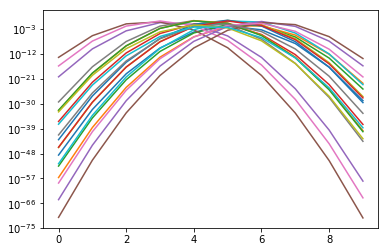

In [275]:
plt.plot(wsabi.lx.reshape((20, 10)).T);
plt.semilogy()

(array([168.,  13.,   5.,   3.,   2.,   1.,   0.,   4.,   2.,   2.]),
 array([2.55322142e-36, 1.81221891e-01, 3.62443783e-01, 5.43665674e-01,
        7.24887566e-01, 9.06109457e-01, 1.08733135e+00, 1.26855324e+00,
        1.44977513e+00, 1.63099702e+00, 1.81221891e+00]),
 <a list of 10 Patch objects>)

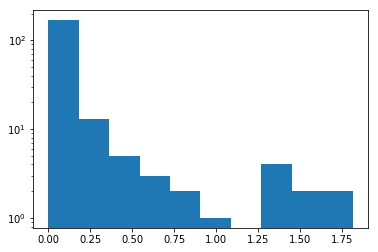

In [276]:
plt.hist(wsabi.lx_transform, log=True)

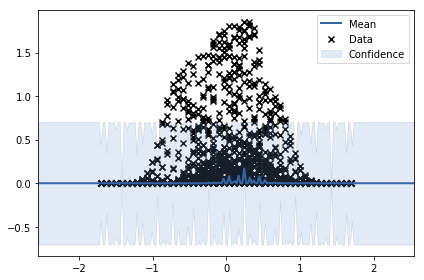

In [289]:
wsabi.m.plot(fixed_inputs=[(0, -1.69774938)])

In [288]:
wsabi.x

array([[-1.69774938, -1.69774938],
       [-1.69774938, -1.62845348],
       [-1.69774938, -1.55915759],
       ...,
       [ 1.69774938,  1.55915759],
       [ 1.69774938,  1.62845348],
       [ 1.69774938,  1.69774938]])

# moments 

In [7]:
mu, std = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-3, -1, 15))

theta = np.column_stack((mu.ravel(), std.ravel()))

In [10]:
approxes = []

for mu, log_std in theta:
    
    std = np.power(10, log_std)
    
    approxes.append(mc.MonteCarlo(m, scipy.stats.norm(mu, std), 1000))
    

In [11]:
m_mu = GPy.models.GPRegression(
    theta, 
    np.array([a.mean() for a in approxes]), 
    GPy.kern.RBF(2, ARD=True))

m_mu.optimize(max_iters=1e5)
m_mu

AssertionError: 

In [449]:
m_mu.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.58011543,+ve,
[1],0.96567622,+ve,


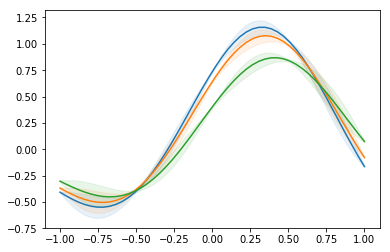

In [456]:
predx = np.zeros((50, 2))
predx[:, 0] = np.linspace(theta[:,0].min(), theta[:,0].max())

for std in [.01, .05, .1]:
    lstd = np.log10(std)
    predx[:,1] = lstd
    
    mu, var = m_mu.predict_noiseless(predx)
    
    plot.interval(predx[:,[0]], mu, var)

In [451]:
m_var = GPy.models.GPRegression(
    theta, 
    np.array([np.log10(a.var()) for a in approxes])[:,None], 
    GPy.kern.RBF(2, ARD=True))

m_var.optimize(max_iters=1e5)
m_var

GP_regression.,value,constraints,priors
rbf.variance,3.0137811540661374,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.03239714148776746,+ve,


In [452]:
m_var.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],2.37362241,+ve,
[1],1.92408436,+ve,


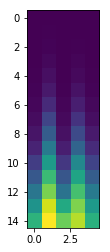

In [454]:
plt.imshow(m_var.Y.reshape(15, 5))

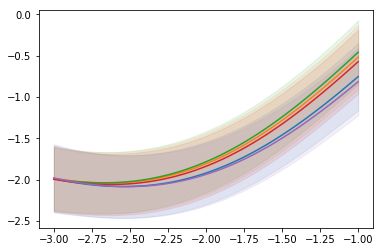

In [455]:
predx = np.zeros((50, 2))
predx[:, 1] = np.linspace(theta[:,1].min(), theta[:,1].max())

for mu in [-1, -.5, 0, .5, 1]:
    predx[:,0] = mu
    
    mu, var = m_var.predict(predx)
    
    plot.interval(predx[:,[1]], mu, var)

In [13]:
from marginal import moment
importlib.reload(moment)

<module 'marginal.moment' from '/Users/pdt2/dev/stochastic-sampling-bayesian-optimization/marginal/moment.py'>

In [14]:
mu, std = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-3, -1, 15))

theta = np.column_stack((mu.ravel(), std.ravel()))

In [15]:
mmnt = moment.Moment(theta, m, 
                    lambda mu, log_std: scipy.stats.norm(mu, np.power(10, log_std)),
                    mc_kwargs = dict(T=1000), ntrain=10
                   )

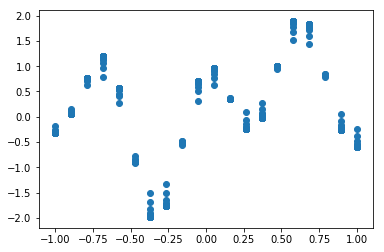

In [17]:
plt.scatter(theta[:,0], mmnt.m_mu.Y)

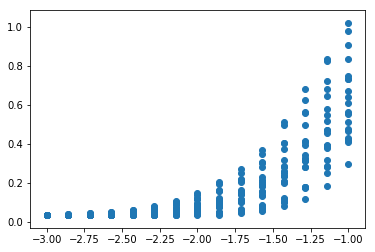

In [18]:
plt.scatter(theta[:,1], mmnt.m_std.Y)

In [19]:
mmnt.m_mu

GP_regression.,value,constraints,priors
rbf.variance,1.7487227874236035,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,7.592428947380498e-05,+ve,


In [20]:
mmnt.m_mu.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.23164271,+ve,
[1],0.94328008,+ve,


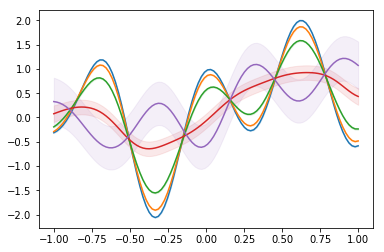

In [21]:
predx = np.zeros((100, 2))
# predx[:, 0] = np.linspace(theta[:,0].min(), theta[:,0].max(), predx.shape[0])
predx[:, 0] = np.linspace(theta[:,0].min(), 1, predx.shape[0])

for std in [.01, .05, .1, .25, .5]:
    lstd = np.log10(std)
    predx[:,1] = lstd
    
    mu, var = mmnt.m_mu.predict_noiseless(predx)
    
    plot.interval(predx[:,[0]], mu, var)

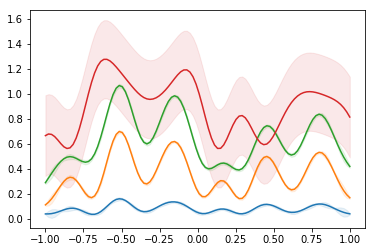

In [22]:
predx = np.zeros((100, 2))
predx[:, 0] = np.linspace(theta[:,0].min(), theta[:,0].max(), predx.shape[0])

for std in [.01, .05, .1, .5]:
    lstd = np.log10(std)
    predx[:,1] = lstd
    
    mu, var = mmnt.m_std.predict_noiseless(predx)
    
    plot.interval(predx[:,[0]], mu, var)

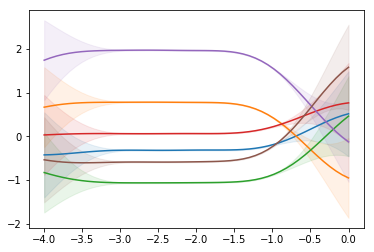

In [23]:
predx = np.zeros((50, 2))
predx[:, 1] = np.linspace(theta[:,1].min(), theta[:,1].max())
predx[:, 1] = np.linspace(-4, 0)

# for mu in [-1, -.5, 0, .5, 1]:
for mu in np.linspace(-1, 1, 6):
    predx[:,0] = mu
    
    mu, var = mmnt.m_mu.predict_noiseless(predx)
    
    plot.interval(predx[:,[1]], mu, var)

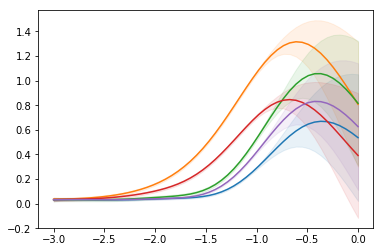

In [24]:
predx = np.zeros((50, 2))
# predx[:, 1] = np.linspace(theta[:,1].min(), theta[:,1].max())
predx[:, 1] = np.linspace(theta[:,1].min(), 0)

for mu in [-1, -.5, 0, .5, 1]:
    predx[:,0] = mu
    
    mu, var = mmnt.m_std.predict_noiseless(predx)
    
    plot.interval(predx[:,[1]], mu, var)

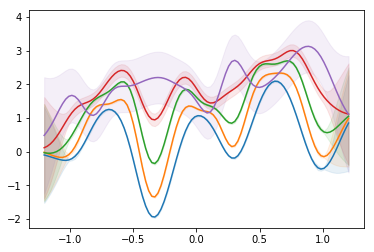

In [25]:
predx = np.zeros((100, 2))
# predx[:, 0] = np.linspace(theta[:,0].min(), theta[:,0].max(), predx.shape[0])
predx[:, 0] = np.linspace(-1.2, 1.2, predx.shape[0])

for std in [.01, .05, .1, .2, .5]:
    lstd = np.log10(std)
    predx[:,1] = lstd
    
    mu, var = mmnt.m_mu.predict_noiseless(predx)
    mu_std, var_std = mmnt.m_std.predict_noiseless(predx)
    
    #plot.interval(predx[:,[0]], mu+2*np.power(10,mu_std), var+4*var_std)
    plot.interval(predx[:,[0]], mu+2*mu_std, var+4*var_std)

# numerical 

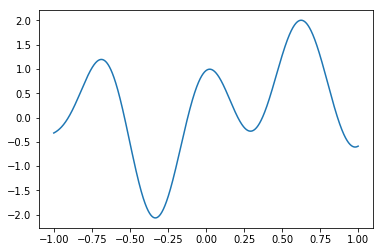

In [29]:
z = np.linspace(-1, 1, 300000)
pfx = scipy.stats.norm(*m.predict(z[:,None]))

plt.plot(z, pfx.mean())

In [78]:
from marginal import numerical
importlib.reload(numerical)

<module 'marginal.numerical' from '/Users/pdt2/dev/stochastic-sampling-bayesian-optimization/marginal/numerical.py'>

In [124]:
num = numerical.Numerical(m, 
                          [scipy.stats.norm(mu, .1) for mu in np.linspace(-.5,.5, 10)],
                          T=1000000, alpha=.001)

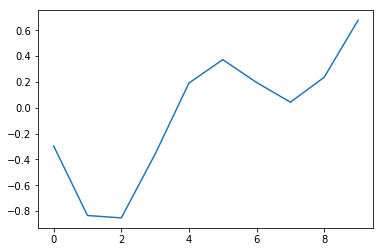

In [125]:
plt.plot(num.mean() + num.var()**2)

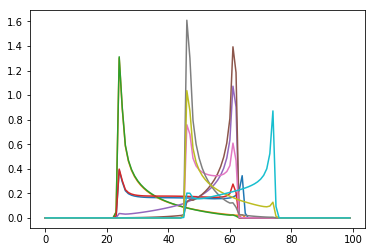

In [126]:
plt.plot(num.pxz.dot(num.pfx.pdf(np.linspace(-4, 4, 100))).T/num.T);

In [127]:
mcs = [mc.MonteCarlo(m, ppx, int(num.T/num.k)) for ppx in num.px]

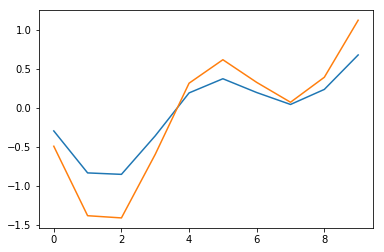

In [128]:
plt.plot(num.mean())
plt.plot([mmc.mean() for mmc in mcs])

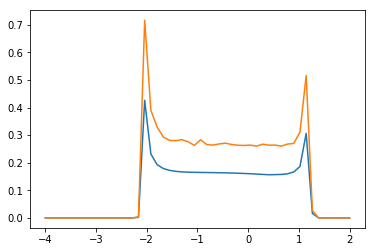

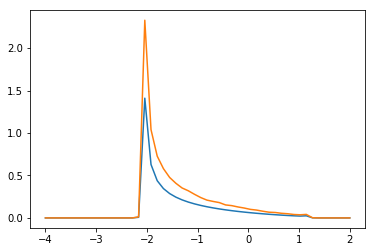

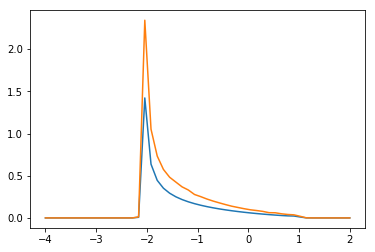

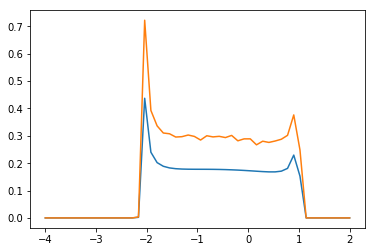

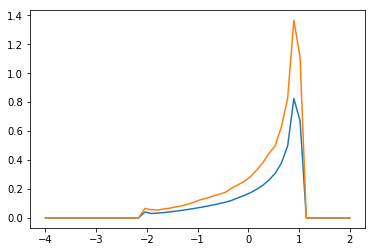

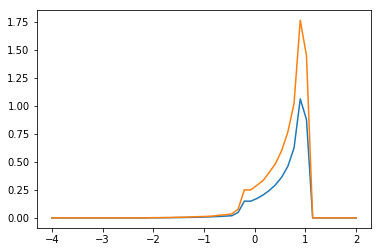

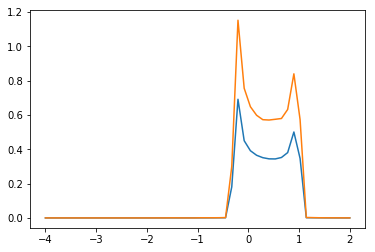

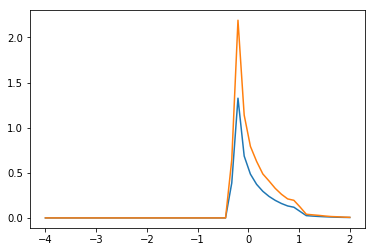

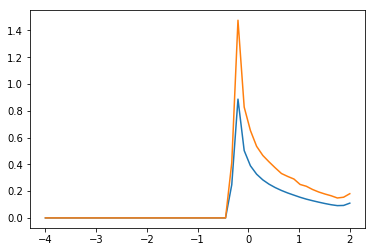

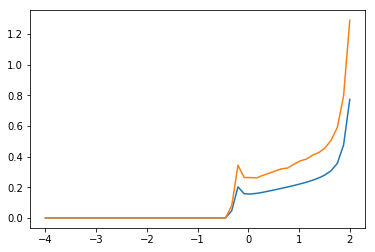

In [129]:
z = np.linspace(-4, 2)
pdf = num.pdf(z)

for i in range(num.k):
    
    plt.figure()
    plt.plot(z, pdf[:,i])
    plt.plot(z, mcs[i].pdf(z))